This file explains how my machine learning algoithm that is used in the MLBacktester class works

Getting and preparing the data

In [11]:
#Import required libiraes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
plt.style.use("seaborn")

In [12]:
#Reading the dataset
data = pd.read_csv("dataset.csv", parse_dates=['time'], index_col='time')
data

,price
time,
2019-01-01 22:00:00+00:00,1.146580
2019-01-01 22:05:00+00:00,1.146350
2019-01-01 22:10:00+00:00,1.146320
2019-01-01 22:15:00+00:00,1.146320
2019-01-01 22:20:00+00:00,1.146530
...,...
2019-12-30 23:35:00+00:00,1.120180
2019-12-30 23:40:00+00:00,1.120210
2019-12-30 23:45:00+00:00,1.120295


In [13]:
#Preparing the data
data["returns"] = np.log(data.div(data.shift(1)))
data.dropna(inplace=True)
data["direction"] = np.sign(data.returns)
data

,price,returns,direction
time,,,
2019-01-01 22:05:00+00:00,1.146350,-0.000201,-1.0
2019-01-01 22:10:00+00:00,1.146320,-0.000026,-1.0
2019-01-01 22:15:00+00:00,1.146320,0.000000,0.0
2019-01-01 22:20:00+00:00,1.146530,0.000183,1.0
2019-01-01 22:25:00+00:00,1.146475,-0.000048,-1.0
...,...,...,...
2019-12-30 23:35:00+00:00,1.120180,-0.000004,-1.0
2019-12-30 23:40:00+00:00,1.120210,0.000027,1.0
2019-12-30 23:45:00+00:00,1.120295,0.000076,1.0


In [14]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = "lag{}".format(lag)
    data[col] = data.returns.shift(lag)
    cols.append(col)
data.dropna(inplace=True)
data

,price,returns,direction,lag1,lag2,lag3,lag4,lag5
time,,,,,,,,
2019-01-01 22:30:00+00:00,1.146455,-0.000017,-1.0,-0.000048,0.000183,0.000000,-0.000026,-0.000201
2019-01-01 22:35:00+00:00,1.146455,0.000000,0.0,-0.000017,-0.000048,0.000183,0.000000,-0.000026
2019-01-01 22:40:00+00:00,1.146370,-0.000074,-1.0,0.000000,-0.000017,-0.000048,0.000183,0.000000
2019-01-01 22:45:00+00:00,1.146315,-0.000048,-1.0,-0.000074,0.000000,-0.000017,-0.000048,0.000183
2019-01-01 22:50:00+00:00,1.146475,0.000140,1.0,-0.000048,-0.000074,0.000000,-0.000017,-0.000048
...,...,...,...,...,...,...,...,...
2019-12-30 23:35:00+00:00,1.120180,-0.000004,-1.0,-0.000112,-0.000018,0.000022,-0.000004,0.000089
2019-12-30 23:40:00+00:00,1.120210,0.000027,1.0,-0.000004,-0.000112,-0.000018,0.000022,-0.000004
2019-12-30 23:45:00+00:00,1.120295,0.000076,1.0,0.000027,-0.000004,-0.000112,-0.000018,0.000022


Predicting the market direction

In [15]:
lm = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")
lm.fit(data[cols], data.direction)
data["pred"] = lm.predict(data[cols])
data

,price,returns,direction,lag1,lag2,lag3,lag4,lag5,pred
time,,,,,,,,,
2019-01-01 22:30:00+00:00,1.146455,-0.000017,-1.0,-0.000048,0.000183,0.000000,-0.000026,-0.000201,1.0
2019-01-01 22:35:00+00:00,1.146455,0.000000,0.0,-0.000017,-0.000048,0.000183,0.000000,-0.000026,1.0
2019-01-01 22:40:00+00:00,1.146370,-0.000074,-1.0,0.000000,-0.000017,-0.000048,0.000183,0.000000,-1.0
2019-01-01 22:45:00+00:00,1.146315,-0.000048,-1.0,-0.000074,0.000000,-0.000017,-0.000048,0.000183,1.0
2019-01-01 22:50:00+00:00,1.146475,0.000140,1.0,-0.000048,-0.000074,0.000000,-0.000017,-0.000048,1.0
...,...,...,...,...,...,...,...,...,...
2019-12-30 23:35:00+00:00,1.120180,-0.000004,-1.0,-0.000112,-0.000018,0.000022,-0.000004,0.000089,1.0
2019-12-30 23:40:00+00:00,1.120210,0.000027,1.0,-0.000004,-0.000112,-0.000018,0.000022,-0.000004,1.0
2019-12-30 23:45:00+00:00,1.120295,0.000076,1.0,0.000027,-0.000004,-0.000112,-0.000018,0.000022,1.0


Simple backtesting

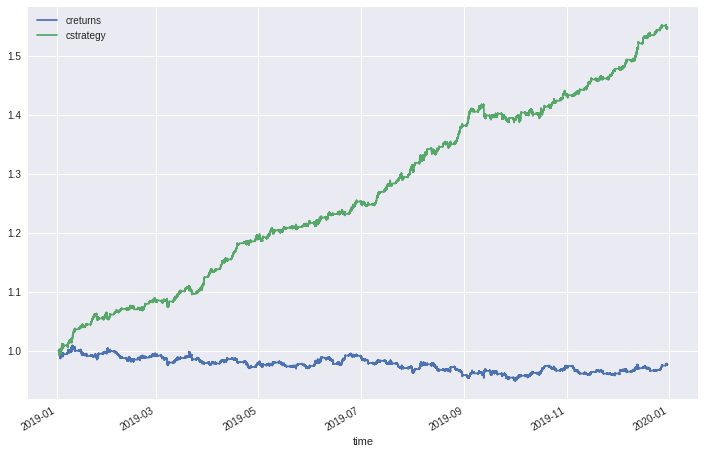

In [16]:
data["strategy"] = data.pred * data.returns
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
data[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

The orange line on the graph graph above shows that the stratergy the machine learning algorithm is implementing would produce a 50% return on investement during the trading year 2019-2020. This however does not take into consideration trading costs. The blue line shows a simple buy and hold startergy to compare to the algorithms statergy

In [17]:
# This code will display the number of trades that the algorithm executed
data["trades"] = data.pred.diff().fillna(0).abs()
data.trades.value_counts()

0.0    44780
2.0    28934
Name: trades, dtype: int64

This algorithm is showing signs of excessive trading. This could mean that this is not the most cost efficent stratergy becuase the more trades the alogirtm takes, the more comission it will have to pay to the executing broker. I am now going to do an out-sample forward test to see how well this current algroithm generalises to unseen data.

Out-sample forward test

In [18]:
data = pd.read_csv("test_set.csv", parse_dates = ["time"], index_col = "time")
data["returns"] = np.log(data.div(data.shift(1)))
data["direction"] = np.sign(data.returns)

lags = 5
cols = []
for lag in range(1, lags + 1):
    col = "lag{}".format(lag)
    data[col] = data.returns.shift(lag)
    cols.append(col)
data.dropna(inplace = True)

data["pred"] = lm.predict(data[cols])

# This will calulate how oftern the algorithm is correct when predicting the change in price. Note, this is not the only factor that matters when trading
# You also need to look at the overall risk to reward ratio, which I will do later.
hits = np.sign(data.direction * data.pred).value_counts()
hit_ratio = hits[1.0] / sum(hits)
hit_ratio


0.508802495897571

The hit ratio for unseen data is very similar to that of the hit ratio of the in sample test, which indicates that we do not have over fitting

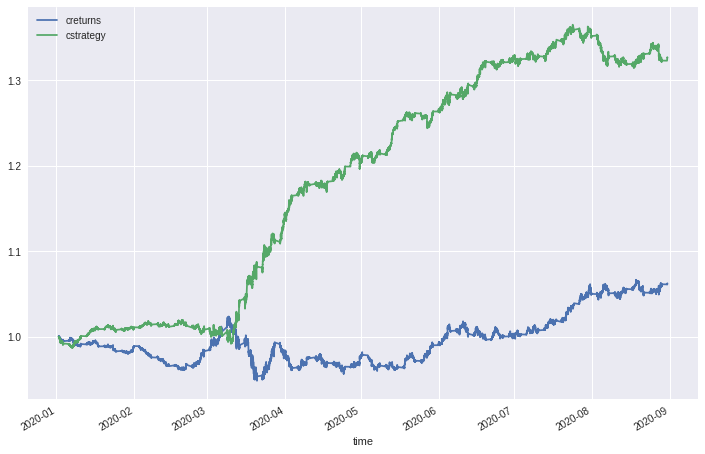

In [19]:
data["strategy"] = data.pred * data.returns
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
data[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

Again the orange line shows the algoirithms performance against the blue lines buy and hold performace. The alogirthm out performs it again and produces a 30% return on investment before trading costs.

In [20]:
data["trades"] = data.pred.diff().fillna(0).abs()
data.trades.value_counts()

0.0    30224
2.0    19137
Name: trades, dtype: int64

I am happy with how the this simple classification model currently performs but I beleive it could be improved upon further by using a more sofisicated classification model and include contraints that will prevent the model of over trading as the commissions on the these unneeded trade will eat away at the algorithms profits.